SMILES : CCC(CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)OCCCC(=O)OC(=O)CC(CC)OC(=O)OCCCC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OCCO)OC(=O)CCCOC(=O)O
Degree : 20
Sequence: ['A', 'B', 'A', 'A', 'D', 'A', 'D', 'A', 'B', 'D', 'A', 'A', 'B', 'A', 'A', 'A', 'D', 'B', 'A', 'D']

Descriptors:
MaxAbsEStateIndex             : 12.96699386304952
MaxEStateIndex                : 12.96699386304952
MinAbsEStateIndex             : 0.015681025086563993
MinEStateIndex                : -1.4787861446358719
qed                           : 0.024731832985296943
SPS                           : 13.214814814814815
MolWt                         : 1946.0090000000002
HeavyAtomMolWt                : 1808.9209999999994
ExactMolWt                    : 1944.8251914919986
NumValenceElectrons           : 770
NumRadicalElectrons           : 0
MaxPartialCharge              : 0.5080517187716004
MinPartialCharge              : -0.462042376396685

[23:44:32] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 


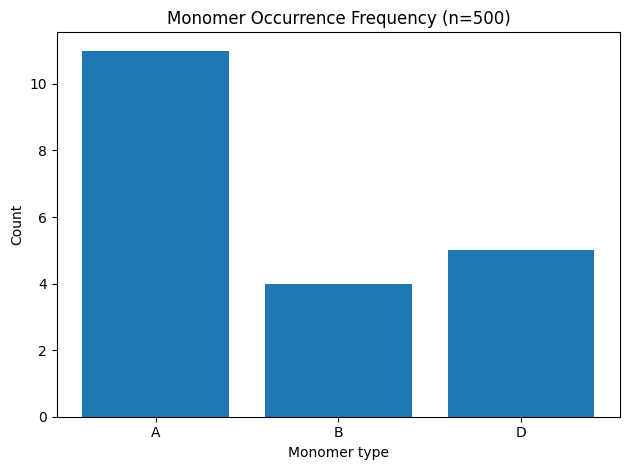

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import random, collections
import collections
from collections import Counter
import matplotlib.pyplot as plt


# 1. モノマー定義
monomers = {
    "A": {"smiles": "OC(CC)CC(=O)O",    "ends": ["OH", "COOH"]},
    "B": {"smiles": "OCCO",             "ends": ["OH", "OH"]},
    "C": {"smiles": "OC(=O)CCC(=O)O",   "ends": ["COOH", "COOH"]},
    "D": {"smiles": "OC(=O)CCCOC(=O)O", "ends": ["COOH", "COOH"]},
}
mole_ratio = {"A":0.5,"B":0.25,"C":0.01,"D":0.24}

# 2. 縮合反応
rxn = AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[OH:4][C:5]>>[C:1](=[O:2])[O:4][C:5]")

# 3. ユーティリティ
def w_choice(d):
    r = random.uniform(0, sum(d.values()))
    s = 0
    for k,w in d.items():
        s += w
        if r<=s:
            return k
    return k

def remove_one(counter, key):
    if counter[key] > 0:
        counter[key] -= 1
        if counter[key] == 0:
            del counter[key]

# 4. ポリマー生成
def build_polymer(target_units=20, seed=None):
    if seed is not None and seed >= 0:     # ★ seed=-1 ならランダム
        random.seed(seed)

    key = w_choice(mole_ratio)
    polymer   = Chem.MolFromSmiles(monomers[key]["smiles"])
    Chem.SanitizeMol(polymer)
    ends      = collections.Counter(monomers[key]["ends"])
    units     = 1
    sequence  = [key]                       # ★ シーケンス開始

    while units < target_units:
        # 末端にマッチする候補
        if   "OH"  in ends and "COOH" not in ends:
            pool = {m:w for m,w in mole_ratio.items() if "COOH" in monomers[m]["ends"]}
        elif "COOH" in ends and "OH"   not in ends:
            pool = {m:w for m,w in mole_ratio.items() if "OH"   in monomers[m]["ends"]}
        else:
            pool = mole_ratio

        if not pool:
            break

        next_key  = w_choice(pool)
        next_mol  = Chem.MolFromSmiles(monomers[next_key]["smiles"])
        Chem.SanitizeMol(next_mol)
        next_ends = collections.Counter(monomers[next_key]["ends"])

        choices = [
            (polymer, next_mol,  ends.copy(), next_ends.copy()),
            (next_mol, polymer,  next_ends.copy(), ends.copy())
        ]

        reacted = False
        for acid_mol, alc_mol, acid_ends, alc_ends in choices:
            if "COOH" in acid_ends and "OH" in alc_ends:
                prod = rxn.RunReactants((acid_mol, alc_mol))
                if prod:
                    polymer = prod[0][0]
                    Chem.SanitizeMol(polymer)
                    remove_one(acid_ends, "COOH")
                    remove_one(alc_ends,  "OH")
                    ends   = acid_ends + alc_ends
                    units += 1
                    sequence.append(next_key)   # ★ ユニット追加
                    reacted = True
                    break
        if not reacted:
            continue

    return Chem.MolToSmiles(polymer), units, sequence   # ★ 返り値拡張

# 5. 全記述子計算
def calc_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {"ERROR": "Invalid SMILES"}
    Chem.SanitizeMol(mol)
    return {name: func(mol) for name, func in Descriptors.descList}

# 6. 実行例
if __name__ == "__main__":
    smi, dp, seq = build_polymer(target_units=20, seed=-1)  # seed=-1 → ランダム
    print("SMILES :", smi)
    print("Degree :", dp)
    print("Sequence:", seq)                      # ★ シーケンス表示

    descs = calc_all_descriptors(smi)
    print("\nDescriptors:")
    for k, v in descs.items():
        print(f"{k:30}: {v}")

    freq = Counter(seq)

    # plot
    labels = list(freq.keys())
    values = [freq[l] for l in labels]

    plt.figure()
    plt.bar(labels, values)
    plt.title("Monomer Occurrence Frequency (n=500)")
    plt.xlabel("Monomer type")
    plt.ylabel("Count")
    plt.tight_layout()



[23:44:32] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[23:44:32] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[23:44:32] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[23:44:32] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 


DP : 90 
Used : {'A': 40, 'E': 4, 'C': 15, 'D': 15, 'B': 12, 'F': 4} 
Remain: {'A': 0, 'B': 8, 'C': 0, 'D': 0, 'E': 1, 'F': 1}


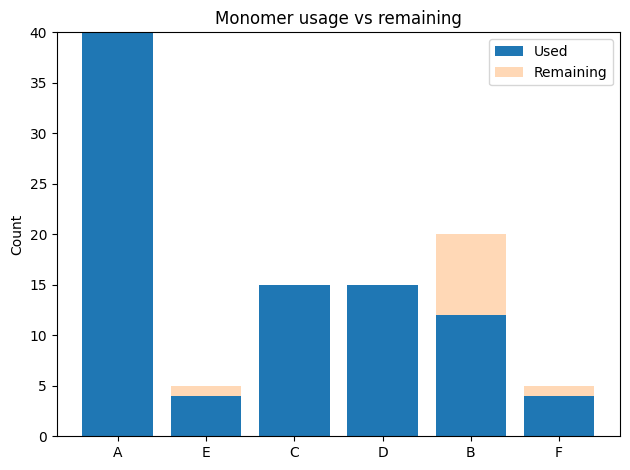

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from collections import Counter
import matplotlib.pyplot as plt

# ─── 1. モノマー定義 ───
monomers = {
    "A": {"smiles": "OC(CC)CC(=O)O", "ends": ["OH", "COOH"]},
    "B": {"smiles": "OCCO",          "ends": ["OH", "OH"]},
    "C": {"smiles": "OC(=O)CCC(=O)O","ends": ["COOH", "COOH"]},
    "D": {"smiles": "OC(=O)CCCOC(=O)O","ends": ["COOH","COOH"]},
    "E": {"smiles": "NCCN",          "ends": ["NH2", "NH2"]},
    "F": {"smiles": "NCCO",          "ends": ["NH2", "OH"]},
}
mole_ratio = {"A":0.4,"B":0.2,"C":0.15,"D":0.15,"E":0.05,"F":0.05}
TOTAL_UNITS = 100

# ─── 2. 反応 SMARTS（両方向） ───
reactions = [
    # エステル
    AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[OH:4][C:5]>>[C:1](=[O:2])[O:4][C:5]"),
    AllChem.ReactionFromSmarts("[OH:4][C:5].[C:1](=[O:2])[OH:3]>>[C:1](=[O:2])[O:4][C:5]"),
    # アミド（NH:4 でマッピング整合）
    AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[NH2:4]>>[C:1](=[O:2])[NH:4]"),
    AllChem.ReactionFromSmarts("[NH2:4].[C:1](=[O:2])[OH:3]>>[C:1](=[O:2])[NH:4]")
]

# ─── 3. ユーティリティ ───
def init_inventory(ratio, total):
    inv, s = {}, 0
    for k,f in ratio.items():
        n = round(f*total); inv[k]=n; s+=n
    while s<total: k=max(ratio, key=ratio.get); inv[k]+=1; s+=1
    while s>total: k=max(inv, key=inv.get);    inv[k]-=1; s-=1
    return inv

def reacts(fg1, fg2):
    return (fg1=="COOH" and fg2 in ("OH","NH2")) or \
           (fg2=="COOH" and fg1 in ("OH","NH2"))

def weighted_choice(keys, inv):
    # 在庫数に比例して選択
    w_sum = sum(inv[k] for k in keys)
    r = random.uniform(0, w_sum)
    acc = 0
    for k in keys:
        acc += inv[k]
        if r <= acc:
            return k
    return keys[-1]

def remove_one(counter, fg):
    if counter[fg]>0:
        counter[fg]-=1
        if counter[fg]==0: del counter[fg]

# ─── 4. メイン ───
def build_polymer_feed(total_units=TOTAL_UNITS, seed=None,
                       max_retry_step=10, max_global_attempts=1000):
    if seed is not None: random.seed(seed)
    inv = init_inventory(mole_ratio, total_units)

    # 初期
    start = weighted_choice(list(inv.keys()), inv)
    inv[start]-=1
    polymer = Chem.MolFromSmiles(monomers[start]["smiles"])
    Chem.SanitizeMol(polymer)
    ends = Counter(monomers[start]["ends"])
    seq  = [start]

    global_fail = 0
    while sum(inv.values())>0 and global_fail < max_global_attempts:
        # 反応可能候補
        cands = [k for k,n in inv.items() if n and
                 any(reacts(f1,f2) for f1 in ends for f2 in monomers[k]["ends"])]
        if not cands: break

        success = False
        for _ in range(max_retry_step):
            nxt = weighted_choice(cands, inv)
            inv[nxt]-=1
            nxt_mol  = Chem.MolFromSmiles(monomers[nxt]["smiles"])
            Chem.SanitizeMol(nxt_mol)
            nxt_end  = Counter(monomers[nxt]["ends"])

            for acid,base,a_end,b_end in [
                (polymer,nxt_mol,ends.copy(),nxt_end.copy()),
                (nxt_mol,polymer,nxt_end.copy(),ends.copy())
            ]:
                for rxn in reactions:
                    prod = rxn.RunReactants((acid,base))
                    if prod:
                        polymer = prod[0][0]; Chem.SanitizeMol(polymer)
                        remove_one(a_end,"COOH")
                        # どちらの官能基が消えたかチェック
                        if "OH" in b_end:  remove_one(b_end,"OH")
                        elif "NH2" in b_end: remove_one(b_end,"NH2")
                        ends = a_end + b_end
                        seq.append(nxt)
                        success=True; break
                if success: break
            if success: break
            # 失敗→在庫戻し
            inv[nxt]+=1
        if success:
            global_fail = 0
        else:
            global_fail += 1  # 全候補失敗をカウント

    used = Counter(seq)
    return Chem.MolToSmiles(polymer), len(seq), used, inv

# ─── 5. 実行 ───
if __name__ == "__main__":
    smi, dp, used, remain = build_polymer_feed(seed=None)
    print("DP :", dp, "\nUsed :", dict(used), "\nRemain:", dict(remain))

    # 可視化
    plt.bar(used.keys(), used.values(), label="Used")
    plt.bar(remain.keys(), remain.values(),
            bottom=[used.get(k,0) for k in remain],
            alpha=0.3, label="Remaining")
    plt.legend(); plt.ylabel("Count")
    plt.title("Monomer usage vs remaining")
    plt.tight_layout(); plt.show()


In [3]:
from ase import Atoms
from ase.optimize import BFGS, FIRE
from ase.build.rotate import minimize_rotation_and_translation
from ase.neb import NEB
import numpy as np
import matplotlib.pyplot as plt
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# --- アンモニア反応物（傘が上向き） ---
react = Atoms(
    symbols="NH3",
    positions=[
        [0.000, 0.000, 0.000],   # N
        [0.937, 0.000, 0.354],   # H
        [-0.468, 0.811, 0.354],  # H
        [-0.468, -0.811, 0.354], # H
    ],
)
# --- アンモニア生成物（傘が下向き） ---
prod = Atoms(
    symbols="NH3",
    positions=[
        [0.000, 0.000, 0.000],    # N
        [0.937, 0.000, -0.354],   # H
        [-0.468, 0.811, -0.354],  # H
        [-0.468, -0.811, -0.354], # H
    ],
)

# --- 電荷とスピンを設定（中性、一重項） ---
for mol in (react, prod):
    mol.info.update({"charge": 0, "spin": 1})

# --- Calculator を取得 ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1", device="cuda")
calc = FAIRChemCalculator(predictor, task_name="omol")

# --- 反応物・生成物の最適化 ---
for mol in (react, prod):
    mol.calc = calc
    BFGS(mol, logfile=None).run(fmax=0.01)

# --- 回転・並進を合わせる ---
minimize_rotation_and_translation(react, prod)

# --- 中間イメージ生成（全7画像） ---
n_mid = 5
images = []

# 各イメージに独立な calculator を設定
for atoms in [react] + [react.copy() for _ in range(n_mid)] + [prod]:
    atoms = atoms.copy()  # 念のためコピー
    pred = pretrained_mlip.get_predict_unit("uma-s-1", device="cuda")
    atoms.calc = FAIRChemCalculator(pred, task_name="omol")
    images.append(atoms)

# --- NEB セットアップ ---
neb = NEB(
    images,
    k=0.1,
    climb=True,
    allow_shared_calculator=False,
    parallel=False  # MPI使用しない場合はFalse
)
neb.interpolate(method="idpp")

# --- NEB 計算（FIREで最適化） ---
FIRE(neb).run(fmax=0.05, steps=500)

# --- エネルギープロファイルを可視化 ---
energies = np.array([img.get_potential_energy() for img in images])
energies -= energies.min()  # 最小値を0に
plt.plot(range(len(energies)), energies, marker="o")
plt.xlabel("Image")
plt.ylabel("Relative Energy (eV)")
plt.title("NEB Path – UMA-S Potential")
plt.grid(True)
plt.show()


/home/suehara/miniconda3/envs/torch89/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from ase import Atoms
from ase.optimize import BFGS, FIRE
from ase.build import minimize_rotation_and_translation
from ase.neb import NEB
from fairchem.core import pretrained_mlip, FAIRChemCalculator
import numpy as np
import matplotlib.pyplot as plt

# --- 修正した反応SMARTS（原子マッピングを簡素化） ---
rxn = AllChem.ReactionFromSmarts(
    "[C:1](=[O:2])[OH].[OH][C:3]>>[C:1](=[O:2])[O][C:3].[OH2]"
)

# --- 入力分子（反応物） ---
smiles1 = "OC(CC)CC(=O)O"  # 酢酸誘導体
smiles2 = "OCCO"           # エチレングリコール

# 分子の準備（水素追加と3D構造生成）
mol1 = Chem.MolFromSmiles(smiles1)
mol1 = Chem.AddHs(mol1)
AllChem.EmbedMolecule(mol1, randomSeed=1)

mol2 = Chem.MolFromSmiles(smiles2)
mol2 = Chem.AddHs(mol2)
AllChem.EmbedMolecule(mol2, randomSeed=2)

# --- 反応適用 ---
products = rxn.RunReactants((mol1, mol2))
if not products:
    raise RuntimeError("反応に失敗しました。SMARTSと分子が適合していない可能性があります。")

# 生成物を分離
ester_mol = products[0][0]
water_mol = products[0][1]

# サニタイズ前に分子を確認
print("生成物の原子数:", ester_mol.GetNumAtoms())
print("生成物の結合数:", ester_mol.GetNumBonds())

# サニタイズ処理
Chem.SanitizeMol(ester_mol)

# エステルのSMILES取得（水素を暗黙的に）
smiles_ester = Chem.MolToSmiles(ester_mol, allHsExplicit=False)
print("生成物SMILES:", smiles_ester)

# 3D構造生成用に水素を追加
ester_mol = Chem.AddHs(ester_mol)
AllChem.EmbedMolecule(ester_mol, randomSeed=3)

# 水分子の処理
water_mol = Chem.AddHs(Chem.MolFromSmiles("O"))
AllChem.EmbedMolecule(water_mol, randomSeed=4)

# --- Mol → ASE 変換関数 ---
def mol_to_ase(mol):
    conf = mol.GetConformer()
    positions = [list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())]
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atoms = Atoms(symbols=symbols, positions=positions)
    atoms.info.update({"charge": 0, "spin": 1})
    return atoms

# --- ASE 形式で反応物・生成物の構造を作成 ---
react_atoms = mol_to_ase(Chem.CombineMols(mol1, mol2))
prod_combined = Chem.CombineMols(ester_mol, water_mol)
prod_atoms = mol_to_ase(prod_combined)

# --- UMA-S Calculator を生成する関数 ---
def make_calc():
    predictor = pretrained_mlip.get_predict_unit("uma-s-1", device="cuda")
    return FAIRChemCalculator(predictor, task_name="omol")

# --- エネルギー最小化（反応物・生成物） ---
for mol in (react_atoms, prod_atoms):
    mol.calc = make_calc()
    BFGS(mol, logfile=None).run(fmax=0.01)

# --- 並進・回転の揃え ---
minimize_rotation_and_translation(react_atoms, prod_atoms)

# --- NEBイメージの準備（中間5枚 + 両端） ---
n_mid = 5
images = []
for atoms in [react_atoms] + [react_atoms.copy() for _ in range(n_mid)] + [prod_atoms]:
    atoms = atoms.copy()
    atoms.calc = make_calc()
    images.append(atoms)

# --- NEB セットアップ ---
neb = NEB(images, k=0.1, climb=True, allow_shared_calculator=False)
neb.interpolate(method="idpp")

# --- 最小化（FIRE法） ---
FIRE(neb).run(fmax=0.05, steps=500)

# --- エネルギープロファイルのプロット ---
energies = np.array([img.get_potential_energy() for img in images])
energies -= energies.min()
plt.plot(range(len(energies)), energies, marker="o")
plt.xlabel("Image")
plt.ylabel("Relative Energy (eV)")
plt.title("NEB Path – Esterification Reaction (UMA-S)")
plt.grid(True)
plt.show()


[23:28:10] product 1 has no mapped atoms.
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
/tmp/ipykernel_100654/1953883187.py:125: FutureWarning: Please import NEB from ase.mep, not ase.neb.
  neb = NEB(images, k=0.1, climb=True, allow_shared_calculator=False)


ValueError: Images have atoms in different orders

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
generic_neb_from_smiles.py
-------------------------------------------------
● 任意の 2 反応物 SMILES + マップ付き SMARTS を入力
● RDKit で 3 D 構造 → 生成物作成
● 原子順を自動一致（マップ優先＋ハンガリアンのフォールバック）
● 足りない分子（副生成物）を両端に同数だけ追加し総原子数を揃える
● ASE + fairchem(UMA‑S) で NEB を実行し，エネルギープロファイルを出力
"""

# ------------------------- 基本ライブラリ -------------------------
from pathlib import Path
from typing import List, Tuple

import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from rdkit import Chem
from rdkit.Chem import AllChem

from ase import Atoms
from ase.optimize import BFGS, FIRE
from ase.build import minimize_rotation_and_translation
from ase.mep import NEB                       # ← 推奨インポート位置
from fairchem.core import pretrained_mlip, FAIRChemCalculator

import matplotlib.pyplot as plt

# ------------------------- ユーティリティ -------------------------
def prepare_mol(smiles: str, seed: int = 1) -> Chem.Mol:
    """SMILES → 3 D Mol（Sanitize+Hs+Embed+MMFF）"""
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=seed)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol


def rdkit_to_ase(mol: Chem.Mol) -> Atoms:
    """RDKit Mol → ASE Atoms"""
    conf = mol.GetConformer()
    pos = np.array([conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())])
    syms = [a.GetSymbol() for a in mol.GetAtoms()]
    atoms = Atoms(syms, positions=pos)
    atoms.info.update(charge=0, spin=1)
    return atoms


def get_perm_by_map(ref: Chem.Mol, target: Chem.Mol) -> List[int]:
    """AtomMapNum を用いた順序合わせ（完全一致前提）"""
    ref_map = {a.GetAtomMapNum(): i for i, a in enumerate(ref.GetAtoms())}
    perm = [None] * target.GetNumAtoms()
    for j, a in enumerate(target.GetAtoms()):
        m = a.GetAtomMapNum()
        if m == 0 or m not in ref_map:
            raise ValueError("マップ番号が足りません")
        perm[ref_map[m]] = j
    return perm


def hungarian_perm(ref_atoms: Atoms, tgt_atoms: Atoms) -> List[int]:
    """マップが足りない場合のフォールバック：ハンガリアンで最近接対応"""
    if sorted(ref_atoms.get_chemical_symbols()) != sorted(
        tgt_atoms.get_chemical_symbols()
    ):
        raise ValueError("原子種が一致しません（フォールバック不可）")
    D = cdist(ref_atoms.get_positions(), tgt_atoms.get_positions())
    _, col = linear_sum_assignment(D)
    return col.tolist()


def reorder_atoms(at: Atoms, perm: List[int]) -> Atoms:
    """Atoms オブジェクトを perm で並べ替えて新インスタンスを返す"""
    new = at[perm]
    new.set_positions(at.get_positions()[perm])
    return new


def make_calc():
    """UMA-S calculator"""
    pred = pretrained_mlip.get_predict_unit("uma-s-1", device="cuda")
    return FAIRChemCalculator(pred, task_name="omol")


def add_dummy_mols(atoms: Atoms, n_dummy: int, box_shift: np.ndarray) -> Atoms:
    """不足分子数だけ水（H2O）をダミーで配置（遠くへシフト）"""
    dummy = []
    for i in range(n_dummy):
        w = prepare_mol("O", seed=100 + i)   # 水を 3 D 化
        a = rdkit_to_ase(w)
        a.translate(box_shift * (i + 1))
        dummy.append(a)
    return atoms + sum(dummy, Atoms())


# ------------------------- メイン処理 -------------------------
def run_neb(
    smi_a: str,
    smi_b: str,
    rxn_smarts: str,
    n_mid: int = 5,
    fmax_geo: float = 0.01,
    fmax_neb: float = 0.05,
):
    # 1) 反応物 Mol
    mol_a, mol_b = prepare_mol(smi_a, 1), prepare_mol(smi_b, 2)

    # 2) 反応適用（マップ付き SMARTS 必須）
    rxn = AllChem.ReactionFromSmarts(rxn_smarts)
    prod_sets = rxn.RunReactants((mol_a, mol_b))
    if not prod_sets:
        raise RuntimeError("SMARTS 反応に失敗しました")

    

    prod_mols = []
    for raw in prod_sets[0]:
        # ① サニタイズ（失敗したら SMILES 経由で再構築）
        try:
            Chem.SanitizeMol(raw)
            mol_ok = raw
        except Exception:
            mol_ok = Chem.MolFromSmiles(Chem.MolToSmiles(raw, isomericSmiles=True))
            Chem.SanitizeMol(mol_ok)
        # ② AddHs → 3D 化
        mol_ok = Chem.AddHs(mol_ok)
        AllChem.EmbedMolecule(mol_ok, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol_ok)
        prod_mols.append(mol_ok)

    for m, s in zip(prod_mols, range(10, 10 + len(prod_mols))):
        AllChem.EmbedMolecule(m, randomSeed=s)
        AllChem.MMFFOptimizeMolecule(m)

    # 3) Reactant → Atoms
    react_comb = Chem.CombineMols(mol_a, mol_b)
    react_atoms = rdkit_to_ase(react_comb)

    # 4) Product → Atoms（合体）
    prod_comb = Chem.CombineMols(prod_mols[0], prod_mols[1] if len(prod_mols) > 1 else Chem.Mol())
    prod_atoms = rdkit_to_ase(prod_comb)

    # 5) 原子並びを合わせる
    try:
        perm = get_perm_by_map(react_comb, prod_comb)
    except Exception:
        perm = hungarian_perm(react_atoms, prod_atoms)   # ★フォールバック
    prod_atoms = reorder_atoms(prod_atoms, perm)

    # 6) 原子数を合わせる（副生成物が足りない/多い場合）
    n_diff = react_atoms.get_global_number_of_atoms() - prod_atoms.get_global_number_of_atoms()
    if n_diff > 0:
        prod_atoms = add_dummy_mols(prod_atoms, n_diff // 3, np.array([10.0, 0.0, 0.0]))
    elif n_diff < 0:
        react_atoms = add_dummy_mols(react_atoms, (-n_diff) // 3, np.array([-10.0, 0.0, 0.0]))

    # 7) 端点最適化
    for at in (react_atoms, prod_atoms):
        at.calc = make_calc()
        BFGS(at, logfile=None).run(fmax=fmax_geo)

    minimize_rotation_and_translation(react_atoms, prod_atoms)

    # 8) NEB イメージ生成
    images = [react_atoms]
    for i in range(n_mid):
        inter = react_atoms.copy()
        inter.set_positions(
            react_atoms.get_positions()
            + (i + 1) / (n_mid + 1) * (prod_atoms.get_positions() - react_atoms.get_positions())
        )
        inter.calc = make_calc()
        images.append(inter)
    images.append(prod_atoms)

    # 9) NEB 実行
    neb = NEB(images, k=0.1, climb=True, allow_shared_calculator=False)
    neb.interpolate(method="idpp")
    FIRE(neb).run(fmax=fmax_neb, steps=500)

    # 10) プロファイル描画
    E = np.array([img.get_potential_energy() for img in images]) - min(
        img.get_potential_energy() for img in images
    )
    plt.figure()
    plt.plot(range(len(images)), E, "o-")
    plt.xlabel("Reaction Coordinate")
    plt.ylabel("Relative Energy (eV)")
    plt.title("NEB – Generic SMARTS Reaction (UMA‑S)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------- 実行例 -------------------------
if __name__ == "__main__":
    # ★ 好きな SMILES / SMARTS に置き換えればそのまま動く
    RXN_SMARTS = "[C:1](=[O:2])[OH].[OH][C:3]>>[C:1](=[O:2])[O][C:3].[OH2]"
    SMILES_A   = "OC(CC)CC(=O)O"   # 酢酸誘導体
    SMILES_B   = "OCCO"            # エチレングリコール

    run_neb(SMILES_A, SMILES_B, RXN_SMARTS, n_mid=5)


ValueError: 原子種が一致しません（フォールバック不可）

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from ase import Atoms, io
from ase.optimize import BFGS, FIRE
from ase.build import minimize_rotation_and_translation
from ase.neb import NEB
from fairchem.core import pretrained_mlip, FAIRChemCalculator
import matplotlib.pyplot as plt

# 1. XYZファイルの読み込み
react_atoms = io.read('prod.xyz')
prod_atoms = io.read('react.xyz')

# 化学式の確認 (必須)
print("Reactants:", react_atoms.get_chemical_formula())
print("Products:", prod_atoms.get_chemical_formula())

# 原子数と元素が一致するかチェック
assert len(react_atoms) == len(prod_atoms), "原子数が一致しません！"
assert (react_atoms.symbols == prod_atoms.symbols).all(), "元素組成が一致しません！"

# 2. 電荷・スピン設定 (UMA-Sでは無視されるが念のため設定)
for mol in [react_atoms, prod_atoms]:
    mol.info.update({"charge": 0, "spin": 1})

# 3. UMA-S Calculatorの生成関数
def make_calc():
    predictor = pretrained_mlip.get_predict_unit("uma-s-1", device="cuda")
    return FAIRChemCalculator(predictor, task_name="omol")

# 4. 構造最適化 (反応物と生成物)
print("\n構造最適化を開始...")
for i, mol in enumerate([react_atoms, prod_atoms]):
    mol.calc = make_calc()
    optimizer = BFGS(mol, logfile=None)
    optimizer.run(fmax=0.01)
    print(f"構造 {i+1} 最適化完了: 最大力 {optimizer.fmax:.4f} eV/Å")

# 5. 構造の位置合わせ
minimize_rotation_and_translation(react_atoms, prod_atoms)


/home/suehara/miniconda3/envs/torch89/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reactants: C7H16O5
Products: C7H16O5

構造最適化を開始...


INFO:root:Setting random seed to 41


構造 1 最適化完了: 最大力 0.0100 eV/Å


INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41


構造 2 最適化完了: 最大力 0.0100 eV/Å


/tmp/ipykernel_13214/2827791043.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


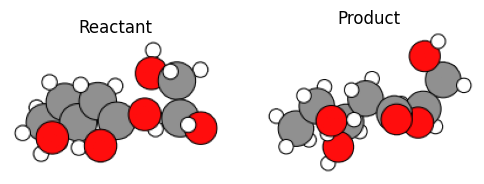

In [2]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

write("./curtius_react.png", react_atoms, rotation="0x,0y,0z")
write("./curtius_prod.png", prod_atoms, rotation="0x,0y,0z")

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax0, ax1 = axes
ax0.imshow(mpimg.imread("./curtius_react.png"))
ax0.set_axis_off()
ax0.set_title("Reactant")
ax1.imshow(mpimg.imread("./curtius_prod.png"))
ax1.set_axis_off()
ax1.set_title("Product")
fig.show()

In [5]:
from ase.visualize import view

view([react_atoms, prod_atoms], representations=["ball+stick"], replace_structure=True)


<Popen: returncode: None args: ['/home/suehara/miniconda3/envs/torch89/bin/p...>

In [ ]:

# 6. NEBイメージの準備
n_mid = 15  # 中間イメージ数
print(f"\nNEB準備: {n_mid}個の中間イメージを作成")
images = [react_atoms]
for i in range(n_mid):
    img = react_atoms.copy()
    img.calc = make_calc()
    images.append(img)
images.append(prod_atoms)

# 7. NEB初期化と補間
neb = NEB(images, k=0.1, climb=True, allow_shared_calculator=False)
neb.interpolate()  

# 8. NEB計算実行
print("\nNEB計算を開始...")
optimizer = FIRE(neb)
optimizer.run(fmax=0.05, steps=500)
print(f"NEB収束: 最大力 {optimizer.fmax:.4f} eV/Å")

# 9. エネルギー経路のプロット
print("\nエネルギー経路をプロット...")
energies = np.array([img.get_potential_energy() for img in images])
min_energy = energies.min()
relative_energies = (energies - min_energy) * 1000  # eV → meVに変換

plt.figure(figsize=(10, 6))
plt.plot(relative_energies, 'o-', linewidth=2, markersize=8)
plt.xlabel("反応座標", fontsize=12)
plt.ylabel("相対エネルギー (meV)", fontsize=12)
plt.title("UMA-SによるNEB計算結果", fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(range(len(images)), [f"Image {i}" for i in range(len(images))])
plt.tight_layout()

# エネルギー値をプロット上に表示
for i, e in enumerate(relative_energies):
    plt.text(i, e+5, f"{e:.1f}", ha='center', fontsize=9)

plt.savefig("neb_path.png", dpi=300)
plt.show()


NEB準備: 15個の中間イメージを作成


INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random seed to 41
INFO:root:Setting random see


NEB計算を開始...
      Step     Time          Energy          fmax
FIRE:    0 01:21:50   -17668.284320      132.449857
FIRE:    1 01:21:52   -17682.437114      124.614318
FIRE:    2 01:21:53   -17699.705860      124.142870
FIRE:    3 01:21:55   -17715.408088       60.673292
FIRE:    4 01:21:57   -17721.591796       31.188130
FIRE:    5 01:21:58   -17725.493951       24.551104
FIRE:    6 01:22:00   -17728.418020       17.962714
FIRE:    7 01:22:02   -17730.309280       12.520806
FIRE:    8 01:22:03   -17731.641511       13.240321
FIRE:    9 01:22:05   -17732.326330       13.924776
FIRE:   10 01:22:06   -17732.945318       13.654092


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 5.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y ./curtius_NEB.gif


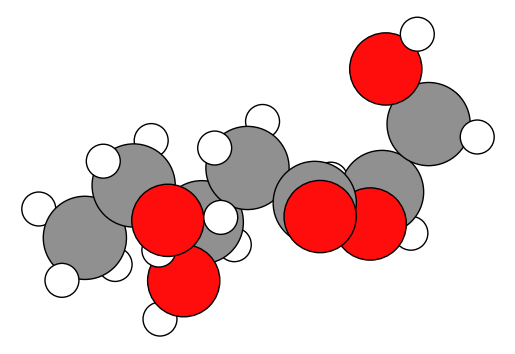

In [7]:
import ase

fig = plt.figure(facecolor="white")
ax = fig.add_subplot()
ase.io.write(
    "./curtius_NEB.gif",
    images,
    format="gif",
    ax=ax
)
